In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
from datetime import datetime

import numpy as np
import folium
import pandas as pd
import xarray as xr
from folium import plugins
from ocean_navigation_simulator.env.data_sources.DrifterData import DrifterData
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import lux
import os

dataset_drifter = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_GLO_UV_NRT_OBSERVATIONS_013_048',#name of the In Situ Near Real Time product in the GLO area
    'name': 'drifter',# name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_latest.txt', 'index_monthly.txt', 'index_history.txt'], #files describing the content of the lastest, monthly and history netCDF file collections available withint he above dataset
    'index_platform': 'index_platform.txt', #files describing the network of platforms contributing with files in the above collections
}
dataset_argo = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_GLO_UV_NRT_OBSERVATIONS_013_048',#name of the In Situ Near Real Time product in the GLO area
    'name': 'argo',# name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_history.txt'], #files describing the content of the lastest, monthly and history netCDF file collections available withint he above dataset
}

# define initial area of interest in order to increase speed
targeted_geospatial_lat_min = 17.0  # enter min latitude of your bounding box
targeted_geospatial_lat_max = 32.0  # enter max latitude of your bounding box
targeted_geospatial_lon_min = -120.0 # enter min longitude of your bounding box
targeted_geospatial_lon_max = -140.0 # enter max longitude of your bounding box
targeted_bbox = [targeted_geospatial_lon_min, targeted_geospatial_lat_min, targeted_geospatial_lon_max, targeted_geospatial_lat_max]  # (minx [lon], miny [lat], maxx [lon], maxy [lat])

# define intial time range of interest
targeted_time_range = '2021-01-01T00:00:00Z/2021-01-31T23:59:59Z'

config = {
    'data_dir': '/home/jonas/Documents/Thesis/OceanPlatformControl/data',
    'dataset': dataset_drifter,
    'targeted_bbox': targeted_bbox,
    'area_overlap_type': 'intersects',
    'targeted_time_range': targeted_time_range,
    'usr': "mmariuswiggert",
    "pas": "tamku3-qetroR-guwneq"
}

In [80]:
# Vis location of bbox
x_loc = (targeted_bbox[0]+ targeted_bbox[2])/2
y_loc = (targeted_bbox[1]+ targeted_bbox[3])/2
f = folium.Figure(width=500, height=500)
m = folium.Map(location=[y_loc, x_loc], zoom_start=4).add_to(f)
points = [(targeted_bbox[1], targeted_bbox[0]), (targeted_bbox[3], targeted_bbox[2])]
folium.Rectangle(bounds=points, color='#ff7800').add_to(m)
f

In [36]:
# download and load index files
drifter_data = DrifterData(config, read_only=True)
info = drifter_data.index_data
info.transpose()

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
# product_id,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,...,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01,COP-GLOBAL-01
file_name,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...,ftp://nrt.cmems-du.eu/Core/INSITU_GLO_UV_NRT_O...
geospatial_lat_min,30.809,29.322,30.535,15.966,30.364,25.181,21.997,17.559,21.711,16.417,...,1.991,1.782,2.242,26.74,15.064,31.82,31.961,0.633,3.78,28.525
geospatial_lat_max,32.473,41.761,32.004,36.16,32.525,44.192,24.221,48.147,22.527,22.9,...,34.257,23.108,23.441,31.285,43.049,43.185,42.448,22.53,30.426,43.673
geospatial_lon_min,-140.483,152.576,-140.264,-157.059,-132.925,-151.223,-137.699,-157.867,-124.747,-132.464,...,173.173,-159.02,-158.022,-148.529,121.047,160.317,161.44,-167.822,-167.052,-135.496
geospatial_lon_max,-139.192,-135.141,-138.96,-131.505,-131.268,-125.637,-133.654,-124.286,-123.402,-115.055,...,-139.725,-91.262,-92.664,-139.324,-136.623,-132.485,-129.462,-86.109,-125.441,-127.639
time_coverage_start,2021-01-01T00:00:00Z,2018-08-09T05:00:00Z,2021-01-01T00:00:00Z,2019-08-11T00:00:00Z,2021-01-01T00:00:00Z,2019-08-19T20:00:00Z,2021-01-01T00:00:00Z,2019-08-21T01:00:00Z,2021-01-01T00:00:00Z,2020-07-26T00:00:00Z,...,2020-04-01T01:00:00Z,2020-03-17T13:00:00Z,2020-03-16T20:00:00Z,2020-08-07T16:00:00Z,2016-10-31T18:00:00Z,2019-11-03T01:00:00Z,2019-11-03T09:00:00Z,2020-02-26T22:00:00Z,2018-09-23T00:00:00Z,2020-08-20T08:00:00Z
time_coverage_end,2021-01-31T23:00:00Z,2022-04-30T23:00:00Z,2021-01-31T23:00:00Z,2022-04-30T23:00:00Z,2021-01-31T23:00:00Z,2021-08-01T12:00:00Z,2021-01-31T23:00:00Z,2021-07-13T14:00:00Z,2021-01-31T23:00:00Z,2021-06-13T12:00:00Z,...,2022-04-30T23:00:00Z,2022-04-30T23:00:00Z,2022-04-30T23:00:00Z,2022-01-15T17:00:00Z,2022-04-24T12:00:00Z,2022-04-24T12:00:00Z,2022-04-24T12:00:00Z,2022-04-30T23:00:00Z,2021-08-24T14:00:00Z,2022-04-30T23:00:00Z
institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,...,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution,Unknown institution
date_update,2021-02-09T06:30:10Z,2022-05-08T17:05:43Z,2021-02-09T06:46:24Z,2022-05-08T20:00:39Z,2021-02-09T06:46:54Z,2022-03-15T19:37:58Z,2021-02-09T06:47:00Z,2021-08-01T18:43:41Z,2021-02-09T06:49:11Z,2021-07-04T20:13:14Z,...,2022-05-15T10:47:25Z,2022-05-15T10:52:41Z,2022-05-15T10:55:18Z,2022-02-07T06:21:53Z,2022-05-02T17:23:31Z,2022-05-02T17:28:30Z,2022-05-02T17:47:14Z,2022-05-02T19:03:49Z,2021-09-06T13:12:42Z,2022-05-02T23:32:47Z


In [25]:
# get test file with wrap-around extremal spatial values
file_name = info.file_name[1].split("/")[-1]
ds = DrifterData.readNCFile(os.path.join(config["data_dir"], "drifter_data", "nc_files", file_name))
display(ds)

from shapely.geometry import Point, box

geospatial_lat_min = float(ds.attrs['geospatial_lat_min'])
geospatial_lat_max = float(ds.attrs['geospatial_lat_max'])
geospatial_lon_min = float(ds.attrs['geospatial_lon_min'])
geospatial_lon_max = float(ds.attrs['geospatial_lon_max']) + 360
# if geospatial_lon_min > geospatial_lon_max:
#     temp = geospatial_lon_min
#     geospatial_lon_min = geospatial_lon_max
#     geospatial_lon_max = temp

bounding_box = box(geospatial_lon_min, geospatial_lat_min, geospatial_lon_max, geospatial_lat_max)
print(list(bounding_box.exterior.coords))

targeted_bounding_box = box(targeted_bbox[0]+360, targeted_bbox[1], targeted_bbox[2]+360, targeted_bbox[3])
print(list(targeted_bounding_box.exterior.coords))
print(targeted_bounding_box.intersects(bounding_box))

<xarray.Dataset>
Dimensions:          (TIME: 23858, LATITUDE: 23858, LONGITUDE: 23858,
                      POSITION: 23858, DEPTH: 3)
Coordinates:
  * TIME             (TIME) datetime64[ns] 2016-09-27T03:00:00 ... 2022-01-23...
  * LATITUDE         (LATITUDE) float32 42.1 42.05 42.01 ... 14.48 14.48 14.48
  * LONGITUDE        (LONGITUDE) float32 148.0 148.0 148.0 ... 123.0 123.0 123.0
Dimensions without coordinates: POSITION, DEPTH
Data variables: (12/21)
    TIME_QC          (TIME) float32 ...
    POSITION_QC      (POSITION) float32 ...
    DC_REFERENCE     (TIME) object ...
    DEPH             (TIME, DEPTH) float32 ...
    DEPH_QC          (TIME, DEPTH) float32 ...
    TEMP             (TIME, DEPTH) float64 ...
    ...               ...
    WSPN_MODEL       (TIME, DEPTH) float64 ...
    WSPN_MODEL_QC    (TIME, DEPTH) float32 ...
    WSTE_MODEL       (TIME, DEPTH) float64 ...
    WSTE_MODEL_QC    (TIME, DEPTH) float32 ...
    WSTN_MODEL       (TIME, DEPTH) float64 ...
    WSTN_MODEL_QC    (TIME, DEPTH) float32 ...
Attributes: (12/48)
    platform_code:                  2101528
    platform_name:                  Drifting Buoy
    wmo_platform_code:              2101528
    ices_platform_code:              
    coriolis_platform_code:         2101528
    site_code:                       
    ...                             ...
    id:                             GL_TS_DC_2101528
    netcdf_version:                 netCDF-4 classic model
    format_version:                 1.4
    Conventions:                    CF-1.6 Copernicus-InSituTAC-FormatManual-...
    date_update:                    2022-02-06T15:07:19Z
    history:                        2022-02-06T15:07:19Z : Creation

[(229.422, 14.209), (229.422, 45.944), (122.991, 45.944), (122.991, 14.209), (229.422, 14.209)]
[(220.0, 17.0), (220.0, 32.0), (240.0, 32.0), (240.0, 17.0), (220.0, 17.0)]
True


In [37]:
# save pd for faster testing
path = os.path.join(config["data_dir"], "drifter_data", "temp.csv")
info.to_csv(path)

In [5]:
# read in csv
path = os.path.join(config["data_dir"], "drifter_data", "temp.csv")
info = pd.read_csv(path)
nc_links = info["file_name"].tolist()
info.shape

(159, 24)

In [105]:
# download all relevant files
nc_links = info["file_name"].tolist()
for i, file_link in enumerate(nc_links):
    # if os.path.exists(file_link)
    # print(f"downloading {i+1}/{len(nc_links)}: {file_link.split('/')[-1]} ...")
    drifter_data.downloadNCFile(file_link)

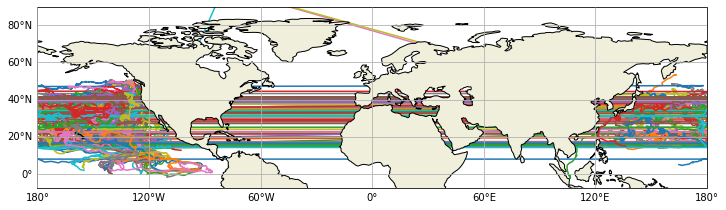

In [7]:
# read-in files and slice relevant data
file_list = [os.path.join(config["data_dir"], "drifter_data", "nc_files", file_link.split('/')[-1]) for file_link in nc_links]
start_time = datetime(2021,1,1)
end_time = datetime(2021,2,1)

# setting up fig
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

# plotting all drifters on same figure
for file_path in file_list:
    ds = DrifterData.readNCFile(file_path)

    # # specify lon and lat mask
    # mask_lon = (ds.LONGITUDE <= targeted_bbox[0]) & (ds.LONGITUDE >= targeted_bbox[2])
    # mask_lat = (ds.LATITUDE >= targeted_bbox[1]) & (ds.LATITUDE <= targeted_bbox[3])

    # below select does not work because exact label does not exist
    ds = ds.sel(TIME=slice(start_time, end_time))
    # u = ds["LONGITUDE"].where(mask_lon & mask_lat).values
    # u = u[np.logical_not(np.isnan(u))]
    # v = ds["LATITUDE"].where(mask_lon & mask_lat).values
    # v = v[np.logical_not(np.isnan(v))]
    u = ds["LONGITUDE"]
    v = ds["LATITUDE"]
    ax.plot(u,v)
plt.show()

In [27]:
# pre-processing to minimise file size

start_time = datetime(2021,1,1)
end_time = datetime(2021,2,1)

column_names = ["time", "lon", "lat", "u", "v", "buoy"]
df = pd.DataFrame(columns = column_names)

for file_path in file_list[1:]:
    ds = DrifterData.readNCFile(file_path)

    # select specific data
    time = ds["TIME"].values
    lon = ds["LONGITUDE"].values
    lat = ds["LATITUDE"].values
    u = ds["NSCT"].isel(DEPTH=-1).values
    v = ds["EWCT"].isel(DEPTH=-1).values
    buoy = [file_path.split("/")[-1].split(".")[0] for i in range(len(time))]
    df_temp = pd.DataFrame({"time":time, "lon":lon, "lat":lat, "u":u, "v":v, "buoy":buoy})

    # filtering conditions
    lon_cond = ((df_temp["lon"] <= targeted_bbox[0]) & (df_temp["lon"] >= targeted_bbox[2]))
    lat_cond = ((df_temp["lat"] >= targeted_bbox[1]) & (df_temp["lat"] <= targeted_bbox[3]))
    time_cond = ((df_temp["time"] >= start_time) & (df_temp["time"] <= end_time))

    # filtering and concat to df
    df_temp = df_temp.loc[(lon_cond & lat_cond & time_cond)]
    df = pd.concat([df, df_temp])

# writing df to file
df.to_csv(os.path.join(config["data_dir"], "drifter_data", "drifter_data_2021_01.csv"), index=False)
print(df.shape)

(27025, 6)


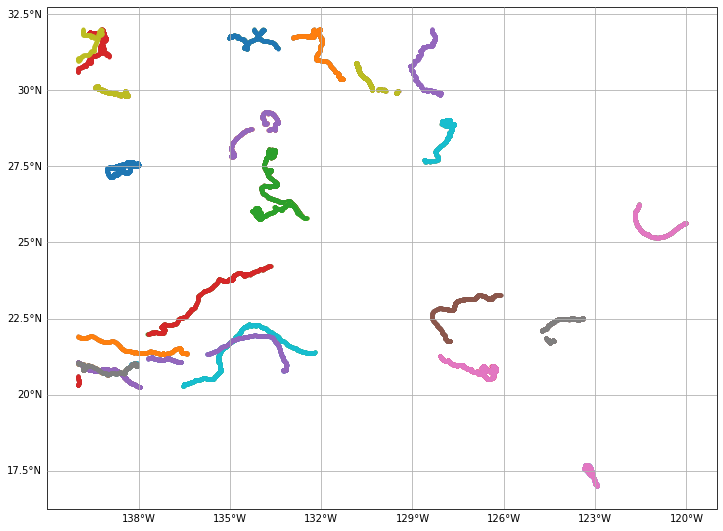

In [21]:
# setting up fig
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

for buoy_name in set(df["buoy"]):
    ax.scatter(df[df["buoy"] == buoy_name]["lon"], df[df["buoy"] == buoy_name]["lat"], marker=".")

In [39]:
df = pd.read_csv(os.path.join(config["data_dir"], "drifter_data", "drifter_data_2021_01.csv"))
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [7]:
# ds[(ds["time"] < datetime(2021,1,1)) & (ds["time"] > datetime(2021,1,1))]
df_filt = df[df["time"] < "2021-01-07"]
df_filt.intent = ["time", "u"]
df_filt

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [13]:
vis = df_filt.exported[0]
with open("/home/jonas/Downloads/test.txt", "w") as f:
    f.write(vis.to_matplotlib())

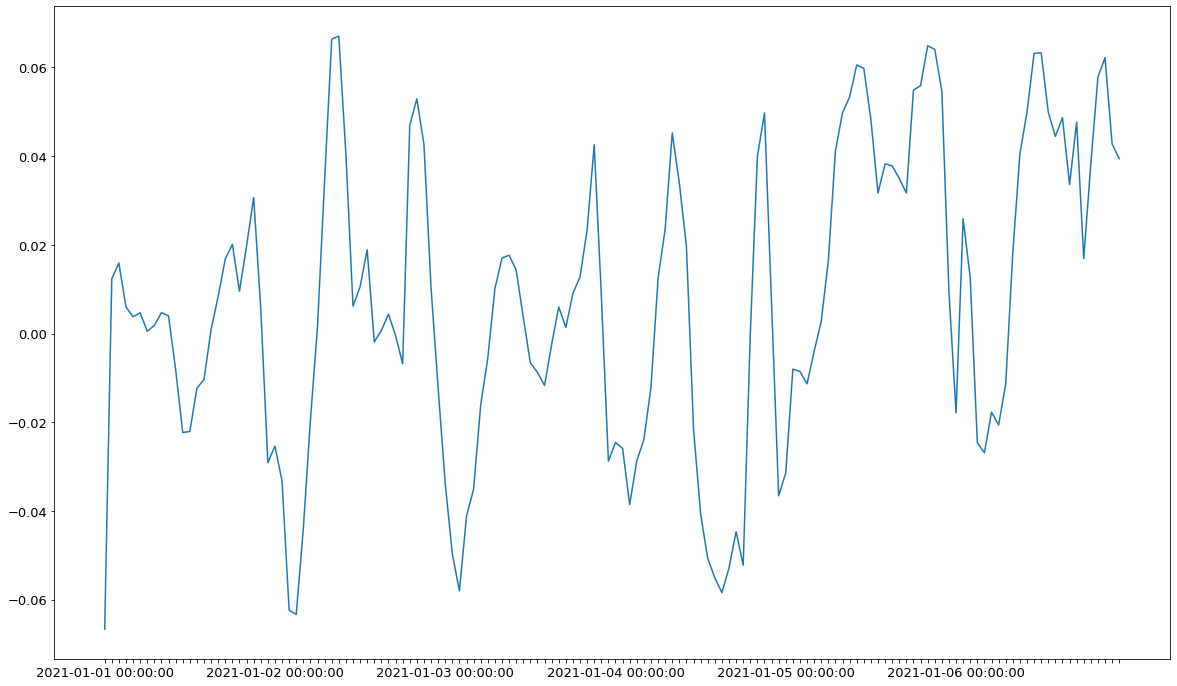

In [41]:
df_filt = df[df["time"] < "2021-01-07"]
df_filt_group = df_filt.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,12))
plt.locator_params(axis='x', nbins=7)
plt.plot(df_filt_group["time"], df_filt_group["u"])

every_nth = 24
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()